Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using DynamicHMCModels, ForwardDiff, Flux, ReverseDiff
gr(size=(400,400))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_d("..", "scripts", "10")
cd(ProjDir)

### snippet 10.4

In [3]:
d = CSV.read(rel_path("..", "data", "chimpanzees.csv"), delim=';');
df = convert(DataFrame, d);
df[:pulled_left] = convert(Array{Int64}, df[:pulled_left])
df[:prosoc_left] = convert(Array{Int64}, df[:prosoc_left])
df[:condition] = convert(Array{Int64}, df[:condition])
df[:actor] = convert(Array{Int64}, df[:actor])
first(df[[:actor, :pulled_left, :prosoc_left, :condition]], 5)

struct m_10_04d_model{TY <: AbstractVector, TX <: AbstractMatrix,
  TA <: AbstractVector}
    "Observations."
    y::TY
    "Covariates"
    X::TX
    "Actors"
    A::TA
    "Number of observations"
    N::Int
    "Number of unique actors"
    N_actors::Int
end

Make the type callable with the parameters *as a single argument*.

In [4]:
function (problem::m_10_04d_model)(θ)
    @unpack y, X, A, N, N_actors = problem   # extract the data
    @unpack β, α = θ  # works on the named tuple too
    ll = 0.0
    ll += sum(logpdf.(Normal(0, 10), β)) # bp & bpC
    ll += sum(logpdf.(Normal(0, 10), α)) # alpha[1:7]
    ll += sum(
      [loglikelihood(Binomial(1, logistic(α[A[i]] + dot(X[i, :], β))), [y[i]]) for i in 1:N]
    )
    ll
end

Instantiate the model with data and inits.

In [5]:
N = size(df, 1)
N_actors = length(unique(df[:actor]))
X = hcat(ones(Int64, N), df[:prosoc_left] .* df[:condition]);
A = df[:actor]
y = df[:pulled_left]
p = m_10_04d_model(y, X, A, N, N_actors);
θ = (β = [1.0, 0.0], α = [-1.0, 10.0, -1.0, -1.0, -1.0, 0.0, 2.0])
p(θ)

-305.21943396408915

Write a function to return properly dimensioned transformation.

In [6]:
problem_transformation(p::m_10_04d_model) =
    as( (β = as(Array, size(p.X, 2)), α = as(Array, p.N_actors), ) )
# Wrap the problem with a transformation, then use Flux for the gradient.
P = TransformedLogDensity(problem_transformation(p), p)

TransformedLogDensity of dimension 9

For stress testing

In [7]:
stresstest = false

#ad = :Flux
ad = :ForwardDiff
#ad = :ReverseDiff

if stresstest
  ∇P = ADgradient(:ForwardDiff, P);
  LogDensityProblems.stresstest(p, N=1000, scale=1.0)
else
  ∇P = LogDensityRejectErrors(ADgradient(ad, P));
end

LogDensityRejectErrors{InvalidLogDensityException,LogDensityProblems.ForwardDiffLogDensity{TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}},Main.##585.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}},ForwardDiff.GradientConfig{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##3#4")){TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}},Main.##585.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}}},Float64},Float64,9,Array{ForwardDiff.Dual{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##3#4")){TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVar

Run N chains

In [8]:
posterior = Vector{Array{NamedTuple{(:β, :α),Tuple{Array{Float64,1},
  Array{Float64,1}}},1}}(undef, 4)

for i in 1:4
  chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
  posterior[i] = TransformVariables.transform.(Ref(problem_transformation(p)),
    get_position.(chain));
end

MCMC, adapting ϵ (75 steps)
0.018 s/step ...done
MCMC, adapting ϵ (25 steps)
0.021 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0087 s/step ...done
MCMC, adapting ϵ (100 steps)
0.006 s/step ...done
MCMC, adapting ϵ (200 steps)
step 194 (of 200), 0.0052 s/step
0.0051 s/step ...done
MCMC, adapting ϵ (400 steps)
step 280 (of 400), 0.0036 s/step
0.0034 s/step ...done
MCMC, adapting ϵ (50 steps)
0.003 s/step ...done
MCMC (1000 steps)
step 268 (of 1000), 0.0037 s/step
step 581 (of 1000), 0.0035 s/step
step 895 (of 1000), 0.0034 s/step
0.0034 s/step ...done
MCMC, adapting ϵ (75 steps)
0.013 s/step ...done
MCMC, adapting ϵ (25 steps)
0.02 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0065 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0038 s/step ...done
MCMC, adapting ϵ (200 steps)
0.0046 s/step ...done
MCMC, adapting ϵ (400 steps)
step 303 (of 400), 0.0033 s/step
0.0033 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0034 s/step ...done
MCMC (1000 steps)
step 306 (of 1000), 0.0033 s/step
step 610

Result rethinking

In [9]:
rethinking = "
      mean   sd  5.5% 94.5% n_eff Rhat
a[1] -0.74 0.27 -1.19 -0.31  2899    1
a[2] 10.77 5.20  4.60 20.45  1916    1
a[3] -1.05 0.28 -1.50 -0.62  3146    1
a[4] -1.05 0.28 -1.50 -0.61  3525    1
a[5] -0.73 0.28 -1.17 -0.28  3637    1
a[6]  0.22 0.27 -0.21  0.67  3496    1
a[7]  1.82 0.41  1.21  2.50  3202    1
bp    0.83 0.27  0.42  1.27  2070    1
bpC  -0.13 0.31 -0.62  0.34  3430    1
";

Set varable names

In [10]:
parameter_names = ["bp", "bpC"]
pooled_parameter_names = ["a[$i]" for i in 1:7]

7-element Array{String,1}:
 "a[1]"
 "a[2]"
 "a[3]"
 "a[4]"
 "a[5]"
 "a[6]"
 "a[7]"

Create a3d

In [11]:
a3d = Array{Float64, 3}(undef, 1000, 9, 4);
for j in 1:4
  for i in 1:1000
    a3d[i, 1:2, j] = values(posterior[j][i][1])
    a3d[i, 3:9, j] = values(posterior[j][i][2])
  end
end

chns = MCMCChains.Chains(a3d,
  vcat(parameter_names, pooled_parameter_names),
  Dict(
    :parameters => parameter_names,
    :pooled => pooled_parameter_names
  )
);

Describe the chain

In [12]:
describe(chns)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = bp, bpC

Empirical Posterior Estimates
──────────────────────────────────────────
parameters
     Mean    SD   Naive SE  MCSE   ESS
 bp 1.5188 3.5890   0.0567 0.0884 1000
bpC 0.4124 0.2503   0.0040 0.0036 1000

Quantiles
──────────────────────────────────────────
parameters
      2.5%    25.0%   50.0%  75.0%  97.5% 
 bp -10.0491 -0.9083 1.5431 3.9255 13.1952
bpC  -0.4224  0.2477 0.4115 0.5787  1.2880



Describe the chain

In [13]:
describe(chns, section=:pooled)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
pooled            = a[1], a[2], a[3], a[4], a[5], a[6], a[7]

Empirical Posterior Estimates
─────────────────────────────────────────────
pooled
       Mean    SD   Naive SE  MCSE   ESS
a[1] -1.9608 3.5901   0.0568 0.0885 1000
a[2] 10.1899 5.9926   0.0948 0.1721 1000
a[3] -2.2631 3.5959   0.0569 0.0881 1000
a[4] -2.2645 3.5971   0.0569 0.0895 1000
a[5] -1.9657 3.5938   0.0568 0.0883 1000
a[6] -1.0401 3.5930   0.0568 0.0882 1000
a[7]  0.5215 3.6036   0.0570 0.0898 1000

Quantiles
─────────────────────────────────────────────
pooled
       2.5%    25.0%   50.0%   75.0%   97.5% 
a[1] -13.9428 -4.3720 -1.9574  0.4906  9.5729
a[2]  -5.2826  5.9850  9.4246 13.9050 36.5143
a[3] -14.0279 -4.6899 -2.2677  0.1595  9.3039
a[4] -14.0163 -4.6832 -2.2715  0.1557  9.3545
a[5] -13.8867 -4.3932 -1.9795  0.4837  9.6300
a[6] -12.4199 -3.4495 -1.0292  1.3889 10.3597
a[7] -10.903

Plot the chain parameters

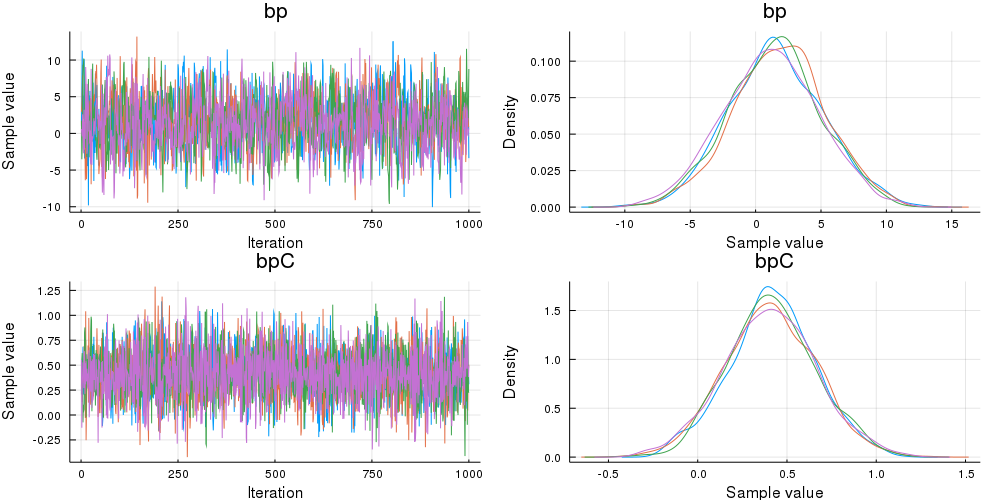

In [14]:
plot(chns)

Plot the chain pooled parameters

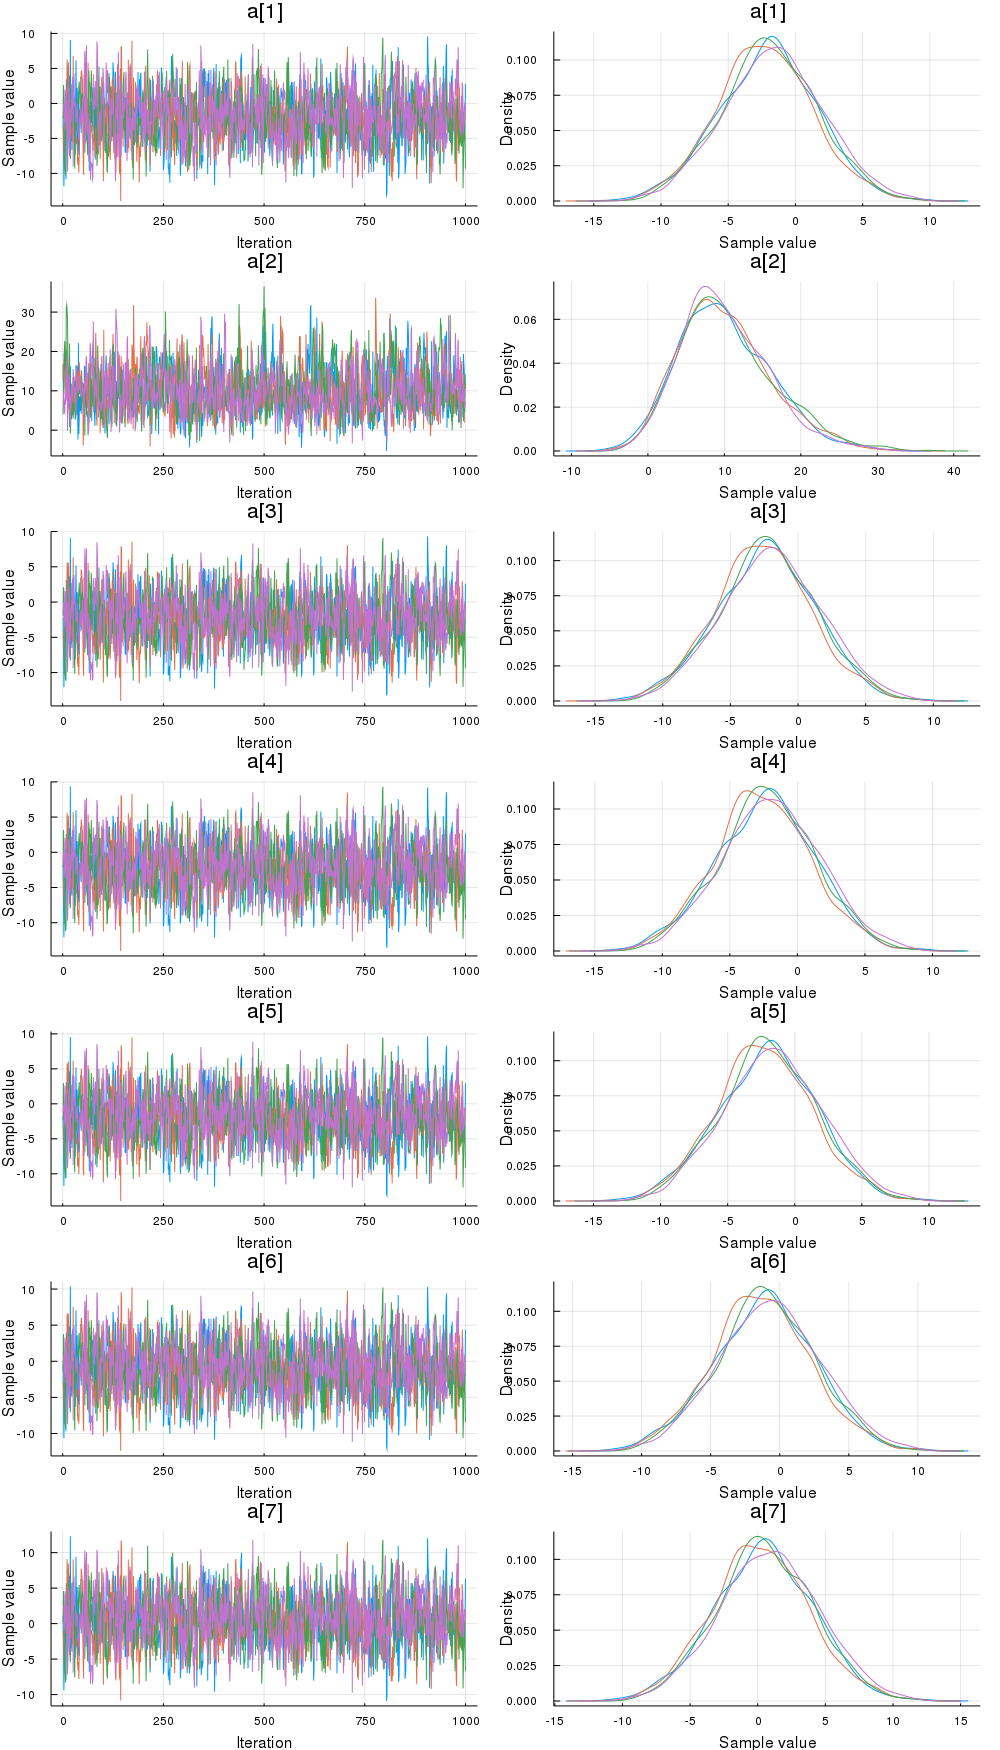

In [15]:
plot(chns, section=:pooled)

End of `m10.04d1.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*